# Calculating Jet Speed

In this notebook, we provide a detailed example on calculating jet speed from a stack of images. We present two different methods for jet speed detemination; an ordinary 2D cross correlation averaged over many image pairs and an average outer product. For each method, we provide the methods in the `microjet_analysis` repo used to calculate jet speeds, and the usage limits of each. The reader should reference the source code for each method for a detailed understanding of each calculation.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Main package imports
from microjet import filters, regions, process, dataio, measure

# Plotting specific imports
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.gridspec as gridspec
import matplotlib as mpl
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

def fullrun_raw_image(stack, ntip_idx, separation=20):
    r'''Make a birds-eye-view image of the full raw image stack
        Useful for a quick view of the full image stack
    '''
    stack = stack[:,:ntip_idx,:]
    n, nx, ny = stack.shape
    g = 0
    for i in range(0, n):
        a = stack[i, :, :].T
#         a -= np.median(a, axis=0)
        a = np.pad(a, [[0, separation*n], [0, 0]])
        g += np.roll(a, i*separation, axis=0)
    return np.array(g)

## Slow, "Easy-to-Analyze" Jets
### Data Preperation

For completeness, we will load an example dataset below and perform the necessary processing steps to clean up the image stack. A detailed example of the steps below is found in the `00_example_full_processing` notebook. Note that for these methods to work, the jet and nozzle must be masked. The preperation steps below perform the standard processing, remove the nozzle tip from the image stack, and masks the jet so only the droplets are visible.

In [2]:
# Load the data stack and the metadata 
image_stack_raw, metadata = dataio.h5_metadata("example_data/001.h5")

# Ensure the data is in float32 format to reduce the amount of data in memory
image_stack_raw = image_stack_raw.astype(np.float32)

# Make a copy of the raw data so we don't mess with it
image_stack = image_stack_raw.copy()

# save the nozzle tip index position
ntip_idx = 1020

# Remove the nozzle tip from the image stack
image_stack = image_stack[:,:ntip_idx,:]

# Normalize the image stack to determine the typical brightness of a jet
for i in range(image_stack.shape[0]):
    # only use nonzero values for the normalization
    nonz = np.nonzero(image_stack[i,:,:])
    # divide by the median pixel value of the whole stack
    image_stack[i, :, :] /= np.median(image_stack[i][nonz])
    
# Filter the image stack using a Sobel filter
image_stack_filtered = filters.sobel(image_stack)

# Threshold the image stack using the hysterisis method
image_stack_thresholded = filters.threshold_hysteresis_clipped(image_stack_filtered, low=.1, high=0.6)

image_stack_thresholded = process.binary_closing(image_stack_thresholded, iterations=1)
image_stack_thresholded = process.binary_erosion(image_stack_thresholded, iterations=1)

# Isolate the droplets
droplet_region = np.array([regions.isolate_droplet_region(im) for im in image_stack_thresholded])

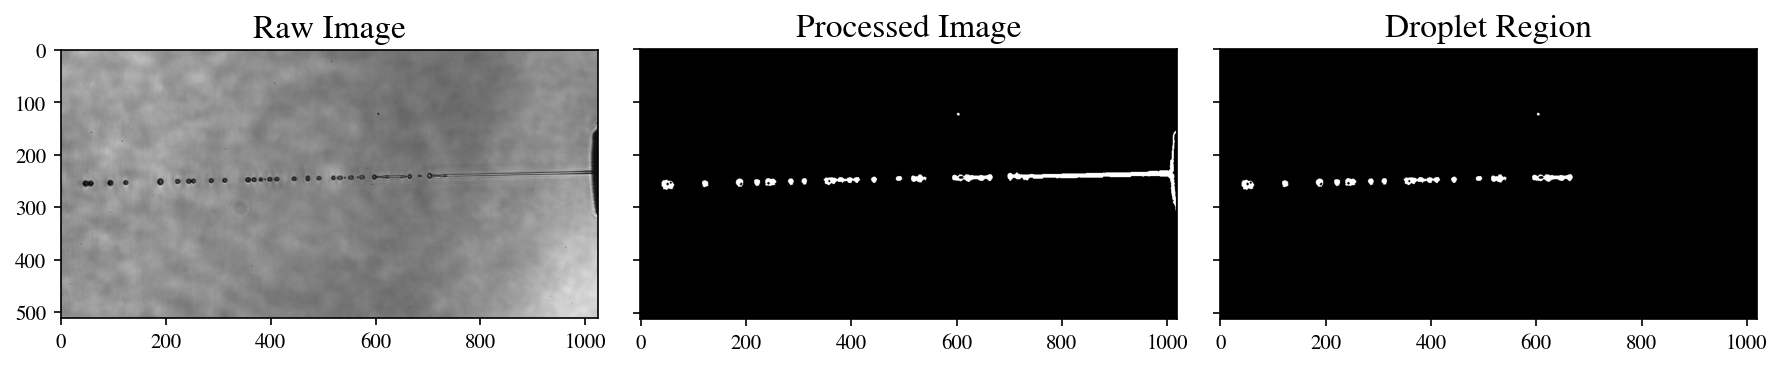

In [3]:
fig, ax = plt.subplots(1,3,figsize=(12,3), tight_layout=True, sharey=True, dpi=150)

ax[0].imshow(image_stack_raw[0].T, cmap='gray')#, vmin=0, vmax=10)
ax[0].set_title("Raw Image", fontsize=16)
ax[1].imshow(image_stack_thresholded[0].T, cmap='gray')
ax[1].set_title("Processed Image", fontsize=16)
ax[2].imshow(droplet_region[0].T, cmap='gray')
ax[2].set_title("Droplet Region", fontsize=16)
plt.show()

### 2D Averaged Cross Correlation

The first method used is an ordinary 2D cross correlation averaged over many image pairs, defined as

\begin{align}
    C_{ij} =  \sum_n \sum_{kl} A^n_{kl} B^n_{k+i, l+j}  
\end{align}

where $A_{ij}^n$ is the $n$-th binary image in a sequence, and $B_{ij}^n$ is the $n$-th time-delayed binary image captured after a delay of $\Delta t$ following $A_{ij}^n$.  The images contain only the droplet regions, which results in a sharp peak in $C_{ij}$ that corresponds to the average displacement vector $\vec{s}$.  The jet velocity is $\vec{v} = \vec{s} \, d_{pixel}/\Delta t$, where $d_\text{pixel}$ is the size a pixel (assumed square).

In [4]:
xcorr, pf, ps = measure.get_stack_cross_correlation(stack=droplet_region)

# Calculate the displacement and convert to jet speed
displacement_xcorr = np.sqrt(pf**2 + ps**2)
jet_speed_xcorr = displacement_xcorr * metadata['pixel_size'] * 1e-6 / (metadata['delay'] * 1e-9)

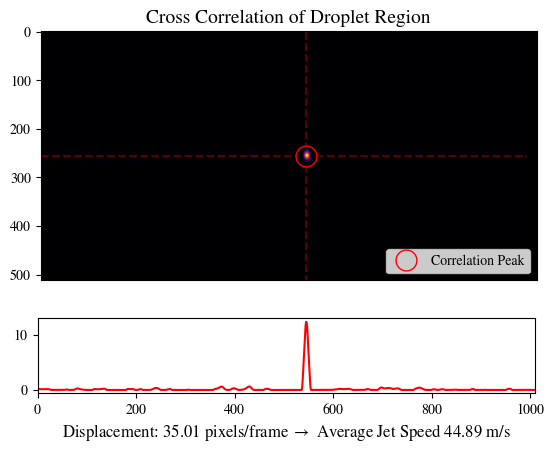

In [5]:
# Visualizing the cross correlation
fig, ax = plt.subplots(dpi=100)

gs = fig.add_gridspec(2, 2,  width_ratios=(6, 1), height_ratios=(1, 4),
                      left=0.12, right=1.05, bottom=0, top=0.2,
                      wspace=0.05, hspace=0.05)

mask = xcorr > 0
cc = xcorr * mask
cc /= np.max(xcorr) 
ax.imshow(cc.T, cmap='inferno', vmin=0, vmax=1)
w = np.where(cc == np.max(cc))
ax.plot(w[0][0], w[1][0], 'o', color='red', markerfacecolor='none', markersize=15, label='Correlation Peak')
ax.vlines(w[0][0], ymin=0, ymax=w[1][0]-20, color='red', linestyle='dashed', alpha=0.35)
ax.vlines(w[0][0], ymax=510, ymin=w[1][0]+20, color='red', linestyle='dashed', alpha=0.35)
ax.hlines(w[1][0], xmin=0, xmax=w[0][0]-20, color='red', linestyle='dashed', alpha=0.35)
ax.hlines(w[1][0], xmax=1000, xmin=w[0][0]+20, color='red', linestyle='dashed', alpha=0.35)
ax.set_title("Cross Correlation of Droplet Region", fontsize=14)
ax.legend(loc='lower right')
ax.set_xticks([])

axp = fig.add_subplot(gs[1, 0])
# Apply a threshold to keep only significant values
threshold_factor = 0.005 #0.000005  # Keep values above 50% of the maximum
threshold_value = threshold_factor * np.max(cc)
cc_thresholded = np.where(cc > threshold_value, cc, 0)

# Summing along the axis with the thresholded data
cc_proj = np.sum(cc_thresholded, axis=1)

# Plotting
axp.plot(cc_proj, 'r')
axp.set_xlim(0,1010)
axp.set_xlabel(fr"Displacement: {displacement_xcorr:0.02f} pixels/frame $\rightarrow$ Average Jet Speed {jet_speed_xcorr:0.02f} m/s", fontsize=12)


plt.show()

### Average Outer Product
The second type of cross correlation is the average outer product 
    \begin{align}
        P_{ij} =  \sum_n a^n_i b^n_j 
    \end{align}
where $a^n_i$ and $b^n_i$ are projections of $A_{ij}^n$ and $B_{ij}^n$ onto the line that best fits the jet. While the correlation $C_{ij}$ tends to be most reliable, the correlation $P_{ij}$ is helpful because it allows for the determination of droplet speeds as a function of distance from the nozzle, and hence enables the detection of droplet acceleration.  For jets produced in vacuum, droplet acceleration is usually negligible and hence the droplet speeds determined from $C_{ij}$. Here, we will determine the jet speed using the $P_{ij}$ method and compare it to the speed calculated from $C_{ij}$. 

Note that the method discussed here uses the droplet centroids as the primary data for the calculation.

In [20]:
op, proj = measure.outer_product_matrix(droplet_region, method='centroid', area_threshold=15)
displacement_op = measure.droplet_translation_by_outer_product(proj)
jet_speed_op = displacement_op * metadata['pixel_size'] * 1e-6 / (metadata['delay'] * 1e-9)

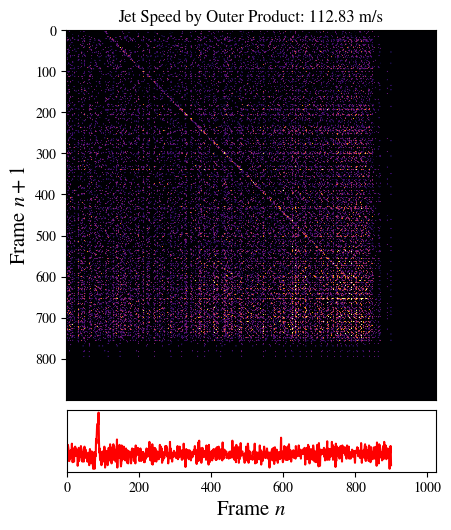

In [21]:
fig, ax = plt.subplots(dpi=100)
ax.imshow(op, vmin=0, vmax=0.5, cmap='inferno')
ax.set_ylabel("Frame $n+1$", fontsize=15)
ax.set_xticks([])

gs = fig.add_gridspec(2, 2,  width_ratios=(6, 1), height_ratios=(1, 4),
                      left=0.225, right=0.915, bottom=-0.04, top=0.125,
                      wspace=0.05, hspace=0.05)

axp = fig.add_subplot(gs[1, 0])
axp.plot(proj, 'r')
axp.set_xlabel("Frame $n$", fontsize=15)
axp.set_yticks([])
axp.set_xlim(0,1024);

ax.set_title(f"Jet Speed by Outer Product: {jet_speed_op:0.2f} m/s")

plt.show()

### Method Comparison
Both methods matched the calculated jet speeds exactly in this case, with a value of $U_j = 44.88$ m/s. While this was the case for this standard dataset, it is possible that the outer product quickly breaks down in the presence of high speed jets. In this case, the droplets may become blurry, throwing off the jet speed calculation. For high speed jets, the cross correlation method with dark field imaging often produces more accurate jet speed values.  In the next sections, we will compare the same data with a darkfield dataset that exhibits whipping and high speed jets. 

## Fast Jets
### Data Preperation


In [10]:
# Load the data stack and the metadata 
image_stack_raw, metadata = dataio.h5_metadata("example_data/303.h5")

# Ensure the data is in float32 format to reduce the amount of data in memory
image_stack_raw = image_stack_raw.astype(np.float32)

# Make a copy of the raw data so we don't mess with it
image_stack = image_stack_raw.copy()

# save the nozzle tip index position
ntip_idx = 900

# Remove the nozzle tip from the image stack
image_stack = image_stack[:,:ntip_idx,:]

# Normalize the image stack to determine the typical brightness of a jet
for i in range(image_stack.shape[0]):
    # only use nonzero values for the normalization
    nonz = np.nonzero(image_stack[i,:,:])
    # divide by the median pixel value of the whole stack
    image_stack[i, :, :] /= np.median(image_stack[i][nonz])
    
# Filter the image stack using a Sobel filter
image_stack_filtered = filters.gausshp(-1*image_stack, sigma=2, truncate=20)

image_stack_thresholded = image_stack_filtered.copy()
# Threshold the image stack using the hysterisis method
image_stack_thresholded = filters.threshold_hysteresis_clipped(image_stack_filtered, low=0.4, high=1.3)
image_stack_thresholded = process.remove_small_objects(image_stack_thresholded, small=10)

# Isolate the droplets
droplet_region = np.array([regions.isolate_droplet_region(im) for im in image_stack_thresholded])

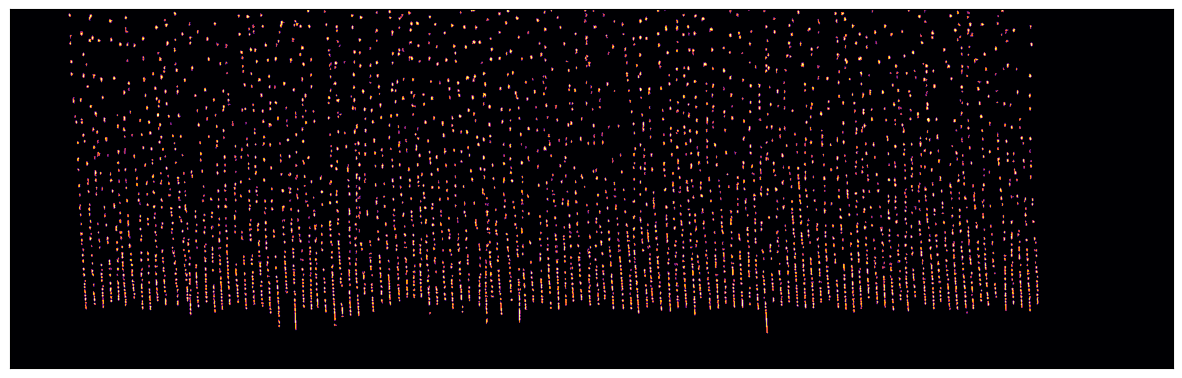

In [11]:
fig, ax = plt.subplots(figsize=(15,5))
ax.imshow(fullrun_raw_image(droplet_region, ntip_idx=-1).T, cmap='inferno', vmin=0, vmax=1)
ax.tick_params(axis='both', which='both', bottom=False, left=False, labelbottom=False, labelleft=False)
plt.show()

## Cross Correlation

In [12]:
xcorr, pf, ps = measure.get_stack_cross_correlation(stack=droplet_region)

# Calculate the displacement and convert to jet speed
displacement_xcorr = np.sqrt(pf**2 + ps**2)
jet_speed_xcorr = displacement_xcorr * metadata['pixel_size'] * 1e-6 / (metadata['delay'] * 1e-9)

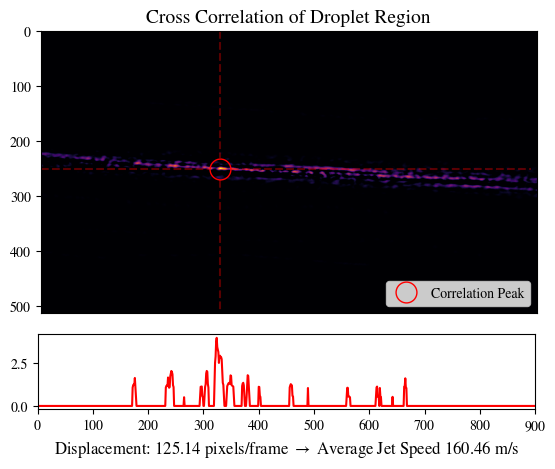

In [13]:
# Visualizing the cross correlation
fig, ax = plt.subplots(dpi=100)

gs = fig.add_gridspec(2, 2,  width_ratios=(6, 1), height_ratios=(1, 4),
                      left=0.12, right=1.05, bottom=0, top=0.2,
                      wspace=0.05, hspace=0.05)

mask = xcorr > 0
cc = xcorr * mask
cc /= np.max(xcorr) 
ax.imshow(cc.T, cmap='inferno', vmin=0, vmax=1)
w = np.where(cc == np.max(cc))
ax.plot(w[0][0], w[1][0], 'o', color='red', markerfacecolor='none', markersize=15, label='Correlation Peak')
ax.vlines(w[0][0], ymin=0, ymax=w[1][0]-20, color='red', linestyle='dashed', alpha=0.35)
ax.vlines(w[0][0], ymax=510, ymin=w[1][0]+20, color='red', linestyle='dashed', alpha=0.35)
ax.hlines(w[1][0], xmin=0, xmax=w[0][0]-20, color='red', linestyle='dashed', alpha=0.35)
ax.hlines(w[1][0], xmax=890, xmin=w[0][0]+20, color='red', linestyle='dashed', alpha=0.35)
ax.set_title("Cross Correlation of Droplet Region", fontsize=14)
ax.legend(loc='lower right')
ax.set_xticks([])

axp = fig.add_subplot(gs[1, 0])
# Apply a threshold to keep only significant values
threshold_factor = 0.5  # Keep values above 50% of the maximum
threshold_value = threshold_factor * np.max(cc)
cc_thresholded = np.where(cc > threshold_value, cc, 0)

# Summing along the axis with the thresholded data
cc_proj = np.sum(cc_thresholded, axis=1)

# Plotting
axp.plot(cc_proj, 'r')
axp.set_xlim(0,900)
axp.set_xlabel(fr"Displacement: {displacement_xcorr:0.02f} pixels/frame $\rightarrow$ Average Jet Speed {jet_speed_xcorr:0.02f} m/s", fontsize=12)


plt.show()

### Outer Product

In [15]:
op, proj = measure.outer_product_matrix(droplet_region, method='centroid', area_threshold=20)
displacement_op = measure.droplet_translation_by_outer_product(proj)
jet_speed_op = displacement_op * metadata['pixel_size'] * 1e-6 / (metadata['delay'] * 1e-9)

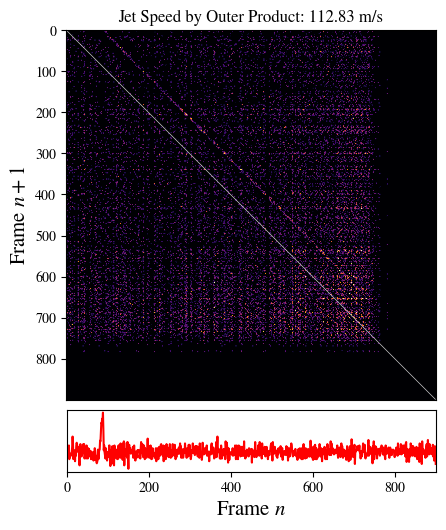

In [16]:
fig, ax = plt.subplots(dpi=100)
ax.imshow(op, vmin=0, vmax=0.5, cmap='inferno')
ax.set_ylabel("Frame $n+1$", fontsize=15)
ax.set_xticks([])
xx = np.arange(900)
ax.plot(xx, xx, '-w', alpha=0.8, linewidth=0.5)

gs = fig.add_gridspec(2, 2,  width_ratios=(6, 1), height_ratios=(1, 4),
                      left=0.225, right=0.915, bottom=-0.04, top=0.125,
                      wspace=0.05, hspace=0.05)

axp = fig.add_subplot(gs[1, 0])
axp.plot(proj, 'r')
axp.set_xlabel("Frame $n$", fontsize=15)
axp.set_yticks([])
axp.set_xlim(0,ntip_idx);

ax.set_title(f"Jet Speed by Outer Product: {jet_speed_op:0.2f} m/s")

plt.show()

### Method Comparison

The 2D Fourier method, in particular, has proven more reliable for such jets, as evidenced by a specific analysis where it measured the jet speed at 160.46 m/s, compared to the 112.83 m/s calculated by the outer product method. This significant difference highlights the advantages of the Fourier technique in handling the high-speed, linear motion characteristic of thin jets. The Fourier method excels due to its ability to robustly handle noise and to capture the global, consistent movements across frames, crucial for accurately tracking these rapid jets. On the other hand, the outer product method, while sensitive to local changes, often falls short in such scenarios. Its tendency to be affected by noise and difficulties in accurately capturing rapid shifts between sequential frames can lead to an underestimation of speed. As a result, for datasets involving fast-moving, thin jets, the 2D Fourier cross-correlation stands out as the more suitable choice, offering a more accurate and holistic view of the jet dynamics by focusing on overall movement trends and minimizing the impact of local discrepancies.



# Fancy Figures

The section below plots the various aspects of the code abow to emphasize certain features.

## Cross Correlation Expanded

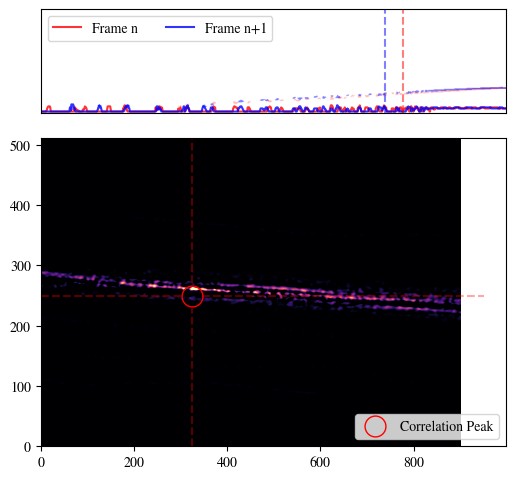

In [17]:
# Define the custom LinearSegmentedColormap 
colors_n = [(0, "white"), (1, "red")]
cmap_n = LinearSegmentedColormap.from_list("custom_colormap", colors_n)
# Define the custom colormap
colors_n1 = [(0, "white"), (1, "blue")]
cmap_n1 = LinearSegmentedColormap.from_list("custom_colormap", colors_n1)

fig = plt.figure(figsize=(8,8), dpi=100)
gs = gridspec.GridSpec(4, 4, wspace=0, hspace=0)
ax_main = plt.subplot(gs[1:3, :3])
ax_xDist = plt.subplot(gs[0, :3])

xr = np.arange(0,np.shape(image_stack[0])[0])
ax_xDist.imshow(image_stack_thresholded[0].T, cmap=cmap_n, alpha=0.5)
ax_xDist.imshow(image_stack_thresholded[1].T, cmap=cmap_n1, alpha=0.5)
ax_xDist.plot(xr, 2*np.sum(image_stack_thresholded[0],axis=1)+152, alpha=0.8, color='red', label=f"Frame n")
ax_xDist.plot(xr, 2*np.sum(image_stack_thresholded[1],axis=1)+152, alpha=0.8, color='blue', label=f"Frame n+1")
ax_xDist.axvline(x=[665], color='blue', linestyle='--', alpha=0.5)
ax_xDist.axvline(x=[700], color='red', linestyle='--', alpha=0.5)
ax_xDist.set_ylim(150,350)
ax_xDist.legend(ncol=2)

fs, ss = np.shape(xcorr)
ax_main.imshow(xcorr.T, cmap='magma', vmin=0, vmax=25, aspect='auto', extent=[0,fs,0,ss])
ax_main.plot(w[0][0], w[1][0], 'o', color='red', markerfacecolor='none', markersize=15, label='Correlation Peak')
ax_main.vlines(w[0][0], ymin=0, ymax=w[1][0]-20, color='red', linestyle='dashed', alpha=0.35)
ax_main.vlines(w[0][0], ymax=510, ymin=w[1][0]+20, color='red', linestyle='dashed', alpha=0.35)
ax_main.hlines(w[1][0], xmin=0, xmax=w[0][0]-20, color='red', linestyle='dashed', alpha=0.35)
ax_main.hlines(w[1][0], xmax=950, xmin=w[0][0]+20, color='red', linestyle='dashed', alpha=0.35)

stuff = [ax_xDist]
for s in stuff:
    s.tick_params(  axis='both',       # changes apply to the x-axis
                    which='both',      # both major and minor ticks are affected
                    bottom=False,      # ticks along the bottom edge are off
                    top=False,         # ticks along the top edge are off
                    labelbottom=False,right=False, left=False, labelleft=False) # labels along the bottom edge are off
ax_main.legend(loc='lower right')
plt.show()

## Outer Product Expanded

In [18]:
labeled = process.label_standard(droplet_region)
centroids, areas = process.get_centroids(labeled, area_threshold=15)
cent_im = measure.centroid_image(droplet_region, area_threshold=15)

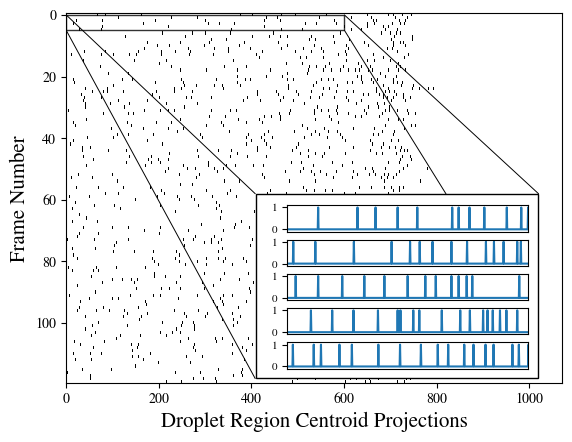

In [19]:
fig, ax = plt.subplots(dpi=100)
p = np.sum(cent_im, axis=2)
ax.imshow(p, cmap='binary', aspect='auto', vmin=0, vmax=1, interpolation='none')
ax.set_xlabel("Droplet Region Centroid Projections", fontsize=15)
ax.set_ylabel("Frame Number", fontsize=15)


roi = mpl.patches.Rectangle((0, 0), 600, 5, linewidth=1, edgecolor='k', facecolor='none', alpha=0.8)
ax.add_patch(roi)

bg = mpl.patches.Rectangle((410, 58), 609, 60, linewidth=1, edgecolor='k', facecolor='w', alpha=1)
ax.add_patch(bg)

ax.plot([0,408], [0,58], 'k', linewidth=0.7)
ax.plot([0,408], [5,118], 'k', linewidth=0.7)
ax.plot([601,1020], [0,58], 'k', linewidth=0.7)
ax.plot([601,820], [5,58], 'k', linewidth=0.7)

n = 5
for i in range(n):
    gs = fig.add_gridspec(2, 2,  width_ratios=(6, 1), height_ratios=(1, 4),
                      left=0.47, right=0.92, bottom=0.14+i/14, top=0.21+i/14,
                      wspace=0.05, hspace=0.05)
    zoom = fig.add_subplot(gs[1, 0])
    zoom.plot(p[i])
    zoom.set_xticks([])
    zoom.set_xlim(0,600);
    zoom.set_ylim(-0.1, 1.1);
    zoom.tick_params(axis='both', which='major', labelsize=8)